In [1]:
import torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/johnwu3/PyHealth/')

from pyhealth.models import Transformer
from pyhealth.interpret.methods.chefer import CheferRelevance


In [2]:
from pyhealth.datasets import MIMIC3Dataset

mimic3_ds = MIMIC3Dataset(
        root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
        tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
        dev=True,
)

print (mimic3_ds.stat())
# data format
mimic3_ds.info()
from pyhealth.tasks import length_of_stay_prediction_mimic3_fn

mimic3_ds = mimic3_ds.set_task(task_fn=length_of_stay_prediction_mimic3_fn)
# stats info
print (mimic3_ds.stat())


{
    "patient_id": "p001",
    "visit_id": "v001",
    "diagnoses": [...],
    "labs": [...],
    "procedures": [...],
    "label": 1,
}

from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader

# data split
train_dataset, val_dataset, test_dataset = split_by_patient(mimic3_ds, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=1, shuffle=False)
mimic3_ds.samples[0].keys()

from pyhealth.models import Transformer
model = Transformer(
        dataset=mimic3_ds,
        # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
        feature_keys=["conditions", "procedures", "drugs"],
        label_key="label",
        mode="multiclass",
    )

print("Testing MIMIC3 STUFF")
sample = test_loader.dataset[0]

print(sample)

print("----")
print(model)
# exit(0)
from pyhealth.trainer import Trainer

trainer = Trainer(
    model=model,
    metrics=["accuracy", "f1_weighted"], # the metrics that we want to log
    )

trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=30,
    monitor="accuracy",
    monitor_criterion="max",optimizer_class=torch.optim.AdamW
)
data_iterator = iter(test_loader)
data = next(data_iterator)
print(data)
model(**data)

relevance = CheferRelevance(model)
# returns a list ofr now
# interpretability code here!
data['class_index'] = data['label']
rel_scores = relevance.get_relevance_matrix(**data)

# weigh and plot these scores and their corresponding feature list
print(rel_scores)


Statistics of base dataset (dev=True):
	- Dataset: MIMIC3Dataset
	- Number of patients: 1000
	- Number of visits: 1054
	- Number of visits per patient: 1.0540
	- Number of events per visit in DIAGNOSES_ICD: 9.2068
	- Number of events per visit in PROCEDURES_ICD: 3.0380
	- Number of events per visit in PRESCRIPTIONS: 29.2457


Statistics of base dataset (dev=True):
	- Dataset: MIMIC3Dataset
	- Number of patients: 1000
	- Number of visits: 1054
	- Number of visits per patient: 1.0540
	- Number of events per visit in DIAGNOSES_ICD: 9.2068
	- Number of events per visit in PROCEDURES_ICD: 3.0380
	- Number of events per visit in PRESCRIPTIONS: 29.2457


dataset.patients: patient_id -> <Patient>

<Patient>
    - visits: visit_id -> <Visit> 
    - other patient-level info
    
    <Visit>
        - event_list_dict: table_name -> List[Event]
        - other visit-level info
    
        <Event>
            - code: str
            - other event-level info



Generating samples for length_of_stay_prediction_mimic3_fn: 100%|██████████| 1000/1000 [00:00<00:00, 80341.42it/s]

### Plot The Relevance of Each Feature


#### Note that normally, there'd be multiple tokens and we would use the tokenizer to visualize explicitly which codes mattered to the prediction, but for now, this is what we get.

[1.4826520681381226, 1.081631064414978, 1.0]


<BarContainer object of 3 artists>

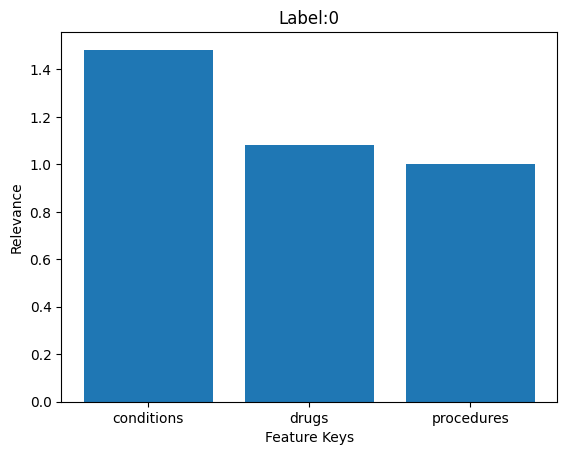

In [ ]:
barPlot = []
barCategories = []
for key in sorted(rel_scores.keys()):
    barPlot.append(float(rel_scores[key].view(-1).detach().cpu()))
    barCategories.append(key)

print(barPlot)
plt.xlabel("Feature Keys")
plt.ylabel("Relevance")
plt.title("Label:" + str(sample['label']))
plt.bar(barCategories, barPlot)